In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from simulation import *
import pickle as pkl
from matplotlib.lines import Line2D
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

In [2]:
## Plotting settings
from plotting_utils import *
params, font = plot_context()
context = sns.plotting_context("paper", rc=params)
sns.set_theme(style="whitegrid", font=font)

In [3]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
    
def plot_conclusion(conclusion_list, metric, ax=None, pretty_name=None, plot_color=None, plot_time=None, plot_range=[20, 400], add_ci=False, plot_ng=True, default_ls=None):
    if ax is None:
        fig, ax = plt.subplots()
    for c, time_range in conclusion_list:
        if plot_time is not None:
            if len(time_range) != 0 and (max(time_range)+1 not in plot_time):
                continue
        x = np.mean(c.avg_metrics['time'], 0)
        if metric == 'mediated_ph2_frac':
            vals = np.array(c.avg_metrics['phase2_mediated']) / (np.array(c.avg_metrics['phase2_mediated']) + np.array(c.avg_metrics['phase2_unmediated'])) * 100
            avg, ci = c.mean_confidence_interval(vals)
            avg = smooth(avg, 2)
            ci = smooth(ci, 2)
        elif metric == 'ph2_bifrac':
            vals_m = np.array(c.avg_metrics['phase2_mediated_bi']) / (np.array(c.avg_metrics['phase2_mediated_mono']) + np.array(c.avg_metrics['phase2_mediated_bi'])) * 100
            vals_um = np.array(c.avg_metrics['phase2_unmediated_bi']) / (np.array(c.avg_metrics['phase2_unmediated_mono']) + np.array(c.avg_metrics['phase2_unmediated_bi'])) * 100
            avg_m, ci_m = c.mean_confidence_interval(vals_m)
            avg_um, ci_um = c.mean_confidence_interval(vals_um)
            avg_m = smooth(avg_m, 2)
            ci_m = smooth(ci_m, 2)
            avg_um = smooth(avg_um, 2)
            ci_um = smooth(ci_um, 2)
        else:
            avg , ci = c.mean_confidence_interval(c.avg_metrics[metric])        
            avg = smooth(avg, 2)
            ci = smooth(ci, 2)*0.5

        if len(time_range) == 0:
            if not plot_ng:
                continue
            label = 'Natural growth'
            color = 'black'
            lw = 3
            alpha = 1
            ls = '-'
        else:
            label = f'Intervention: t={min(time_range)}-{max(time_range)+1}'
            color = 'tab:blue' if plot_color is None else plot_color
            alpha = 0.1 + 0.9 * max(time_range)/plot_range[1]
            lw =2
            ls=default_ls or '-'
            if max(time_range) == 100-1:
                ls=default_ls or '--'
            elif max(time_range) == 200-1:
                ls = default_ls or '-.'
            elif max(time_range) == 300-1:
                ls = ':'
        
        if metric == 'ph2_bifrac':
            ax.plot(x, avg_m, color=color, linestyle='--', alpha=1, lw=lw)
            ax.plot(x, avg_um, color=color, alpha=1, lw=lw)
            if add_ci:
                # add confidence interval
                ax.fill_between(x, avg_m-ci_m, avg_m+ci_m, color=color, alpha=0.17*alpha)
                ax.fill_between(x, avg_um-ci_um, avg_um+ci_um, color=color, alpha=0.17*alpha)
        else:
            ax.plot(x, avg, label=label, color=color, alpha=alpha, lw=lw, linestyle=ls)
            if add_ci:
                # add confidence interval
                ax.fill_between(x, avg-ci, avg+ci, color=color, alpha=0.17*alpha)
    ax.set_xlim(plot_range)
    ax.set(xlabel='Time', ylabel=metric if pretty_name is None else pretty_name)
    return ax

def plot_indirect(unmed_clist, med_clist, metric, ax=None, pretty_name=None, plot_color=None, plot_time=None, plot_range=[20, 400]):
    for i in range(len(med_clist)):
        c_m, time_range0 = med_clist[i]
        c_um, time_range1 = unmed_clist[i]
        if plot_time is not None:
            if len(time_range0) != 0 and (max(time_range0)+1 not in plot_time):
                continue
            
        x = np.mean(c_m.avg_metrics['time'], 0)

        avg_m = np.array(c_m.mean_confidence_interval(c_m.avg_metrics[metric])[0])
        avg_um = np.array(c_um.mean_confidence_interval(c_um.avg_metrics[metric])[0])
        if len(time_range0) == 0:
            label = 'Natural growth'
            color = 'black'
            lw = 3
            alpha = 1
            ax.plot(x, avg_m, label=label, color=color,alpha=alpha, lw=lw)

        else:
            label = f'Intervention: t={min(time_range0)}-{max(time_range0)+1}'
            color = 'tab:blue' if plot_color is None else plot_color
            alpha = 0.3 + 0.7 * max(time_range0)/plot_range[1]
            lw =2
            ax.plot(x, avg_m, label=label, color=color,alpha=alpha, lw=lw)
            ax.plot(x, avg_um, label=label, color=color, linestyle='--', alpha=alpha, lw=lw)
    
    ax.set_xlim(plot_range)
    ax.set(xlabel='Time', ylabel=metric if pretty_name is None else pretty_name)
    return ax

def plot_diff_frac(unmed_clist, med_clist, metric, nat_idx, ax=None, pretty_name=None, plot_color=None, smooth_pts=None, plot_time=None, plot_range=[20, 400]):
    c_nat = med_clist[nat_idx][0]
    for i in range(len(med_clist)):
        c_m, time_range0 = med_clist[i]
        c_um, time_range1 = unmed_clist[i]
        if time_range0 != time_range1:
            return i
        if len(time_range0) == 0 or (max(time_range0)+1 not in plot_time):
            continue
        
        x = np.mean(c_m.avg_metrics['time'], 0)

        avg_m = np.array(c_m.mean_confidence_interval(c_m.avg_metrics[metric])[0])
        avg_um = np.array(c_um.mean_confidence_interval(c_um.avg_metrics[metric])[0])
        avg_nat = np.array(c_nat.mean_confidence_interval(c_nat.avg_metrics[metric])[0])
        avg = (avg_m - avg_um) / (avg_m - avg_nat)
        if smooth_pts is not None:
            avg = smooth(avg, smooth_pts)
        avg = np.clip(avg, 0, None)
        avg[11:14] = 0
        label = f'Intervention: t={min(time_range0)}-{max(time_range0)+1}'
        color = 'tab:blue' if plot_color is None else plot_color
        alpha = 0.3 + 0.7 * max(time_range0)/plot_range[1]
        lw =2
        ax.plot(x, avg, label=label, color=color,alpha=alpha, lw=lw)
    ax.set_xlim(plot_range)
    ax.set(xlabel='Time', ylabel=metric if pretty_name is None else pretty_name)
    return ax


Load experiments

In [4]:
# load experiment results from exp_delayed_effects.py
delayed_exp = defaultdict(list)
      
rec_how  = ['embedding', 'random_fof']
acc_how = ['constant', 'embedding']
intervention_end = list(range(50, 401, 50))
node_removal = [True, False]
edge_removal = [True, False]

settings = list(product(rec_how, acc_how, intervention_end, node_removal, edge_removal))

for (rec, acc, end, node, edge) in settings:
    with open(f'experiments/exp_delayed_effects/{rec}_{acc}_{end}_{node}_{edge}.pkl', 'rb') as f:
        rec_how, acc_how, intervention_end, conclusion = pkl.load(f)
        time_range = list(range(50, intervention_end))
        delayed_exp[(rec, acc, node, edge)].append((conclusion, time_range))

In [5]:
# load experiment results from exp_indirect_effects.py
indirect_exp = defaultdict(list)
      
rec_how  = ['embedding', 'random_fof']
acc_how = ['constant', 'embedding']
intervention_end = list(range(50, 401, 25))
settings = list(product(rec_how, acc_how, intervention_end))

for (rec, acc, end) in settings:
    with open(f'experiments/exp_indirect_effects/{rec}_{acc}_{end}.pkl', 'rb') as f:
        rec_how, acc_how, intervention_end, conclusion = pkl.load(f)
        time_range = list(range(50, intervention_end))
        indirect_exp[(rec, acc)].append((conclusion, time_range))

In [6]:
# load experiment results from exp_group_effects.py
group_exp = defaultdict(list)

settings = ['heterogeneity', 'homogeneity', 'minority_homophily', 'majority_heterophily', 'homo+hetero']        
rec_how  = ['embedding', 'random_fof']
acc_how = ['constant', 'embedding']
intervention_end = list(range(50, 401, 50))
node_removal = [True, False]
edge_removal = [True, False]
p2_mediated = [True, False]

settings = list(product(settings, rec_how, acc_how, intervention_end, node_removal, edge_removal, p2_mediated))

for (grp, rec, acc, end, node, edge, med) in settings:
    try:
        with open(f'experiments/exp_group_effects/{grp}_{rec}_{acc}_{end}_{node}_{edge}_{med}.pkl', 'rb') as f:
            rec_how, acc_how, intervention_end, conclusion = pkl.load(f)
            time_range = list(range(50, intervention_end))
            group_exp[(grp, rec, acc, node, edge, med)].append((conclusion, time_range))
    except:
        pass


In [16]:
# load experiment results from exp_ab.py
ab_exp = defaultdict(list)

rec_how  = ['embedding', 'random_fof']
acc_how = ['constant', 'embedding']
intervention_end = [50, 100, 150, 200, 400]
node_removal = [True, False]
edge_removal = [True, False]
treatment = ['0.1', '0.5', '0.9', 'group1']
counter = 0
settings = list(product(rec_how, acc_how, intervention_end, node_removal, edge_removal, treatment))
print(len(settings))
for (rec, acc, end, node, edge, trt) in settings:
    try:
        with open(f'experiments/exp_ab/{rec}_{acc}_{end}_{node}_{edge}_{trt}.pkl', 'rb') as f:
            rec_how, acc_how, intervention_end, conclusion = pkl.load(f)
            time_range = list(range(50, intervention_end))
            ab_exp[(rec, acc, node, edge, trt)].append((conclusion, time_range))
            counter += 1
    except:
        #print(f'Failed to load {rec}_{acc}_{end}_{node}_{edge}_{trt}.pkl')
        pass
print(f'There are {counter} AB experiments in total')

320
There are 223 AB experiments in total


Plot delayed metrics

In [7]:
%%capture
# plot graphs for delayed effects
acc_how = ['constant', 'embedding']
node_removal = [True, False]
edge_removal = [True, False]
with context:
    metrics = ['homophily_0', 'global_clustering', 'gini_coeff']
    pretty_names = ['Homophily', 'Global clustering', 'Gini coefficient']
    plot_time=[100, 200, 300, 400]
    
    for ah, nr, er in product(acc_how, node_removal, edge_removal):
        fig, ax = plt.subplots(1, 3, figsize=(28, 8),squeeze=False)

        for i, m in enumerate(metrics):
            plot_conclusion(delayed_exp[('embedding', ah, nr, er)], 
                            m, ax=ax[0, i], pretty_name=pretty_names[i], plot_time=plot_time, add_ci=True)
            plot_conclusion(delayed_exp[('random_fof',  ah, nr, er)], 
                            m, ax=ax[0, i], plot_color='tab:orange', pretty_name=pretty_names[i], plot_time=plot_time, add_ci=True, plot_ng=False)
            #ax[0, i].set_xticklabels([])
            #ax[0, i].set_xlabel('')
            # ax[i, 1].set_yticklabels([])
            ax[0, i].set_ylabel('')
            #ax[1, i].set_ylabel('')
            
        # ax[0 ,0].set_ylim([-0.05, 0.35])
        # # ax[1, 0].set_ylim([-0.05, 0.35])
        # ax[0, 1].set_ylim([0.1, 0.25])
        # # ax[1, 1].set_ylim([0.1, 0.25])
        # ax[0, 2].set_ylim([0.29, 0.48])
        # ax[1, 2].set_ylim([0.29, 0.48])

        ax[0, 0].set_title('Homophily')
        ax[0, 1].set_title('Global clustering')
        ax[0, 2].set_title('Gini coefficient')
        # ax[0, 0].set_ylabel('Latent')
        # ax[1, 0].set_ylabel('FoF')
        
        lines = [Line2D([0], [0], color='black', linewidth=3)]
        labels = ['Natural growth']
        ax[0, 0].legend(lines, labels, loc='best')
        
        lines = [Line2D([0], [0], color=c, linewidth=3) for c in ['tab:blue', 'tab:orange']]
        labels = ['Latent', 'FoF']
        ax[0,1].legend(lines, labels, loc='best', title='Recommender')

        alpha = [0.1 + 0.9 * time_range0/400 for time_range0 in plot_time]
        ls = ['--', '-.', ':', '-']
        lines = [Line2D([0], [0], color='tab:gray', linewidth=3, alpha=a, linestyle=ls[idx]) for idx, a in enumerate(alpha)]
        labels = [f'50-{time_range0}' for time_range0 in plot_time]
        ax[0, 2].legend(lines, labels, loc='best', title='Intervention interval')
        
        #plt.tight_layout()
        #plt.show()
        save_fig(fig, name=f'delayed_effects_{ah}_{nr}_{er}')
        

Plot prevalence of mediated connections in Meeting Friends phase
Plot bias in mediated edges

In [8]:
%%capture
acc_how = ['constant']
node_removal = [False]
edge_removal = [False]
metrics = ['mediated_ph2_frac', 'ph2_bifrac']

with context:
    for ah, nr, er in product(acc_how, node_removal, edge_removal):
        if not nr and not er:
            num_cols = 3
        else:
            num_cols = 2
        fig, ax = plt.subplots(1, num_cols, figsize=(28, 8))

        plot_conclusion(delayed_exp[('embedding', ah, nr, er)], 'mediated_ph2_frac', ax=ax[0], pretty_name='', plot_color='tab:blue', plot_time=[100, 200, 400], add_ci=True, default_ls='-')
        plot_conclusion(delayed_exp[('random_fof', ah, nr, er)], 'mediated_ph2_frac', ax=ax[0], pretty_name='', plot_color='tab:orange', plot_time=[100, 200, 400], add_ci=True, plot_ng=False, default_ls="-")
        plot_conclusion(delayed_exp[('embedding', ah, nr, er)], 'ph2_bifrac', ax=ax[1], pretty_name='', plot_color='tab:blue', plot_time=[200], add_ci=True)
        plot_conclusion(delayed_exp[('random_fof', ah, nr, er)], 'ph2_bifrac', ax=ax[1], pretty_name='', plot_color='tab:orange', plot_time=[200], add_ci=True, plot_ng=False)
        if num_cols == 3:
            plot_conclusion(indirect_exp[('embedding', ah)], 'homophily_0', ax=ax[2], pretty_name='', plot_color='tab:blue', plot_time=[100, 200, 400], add_ci=True, plot_ng=True, default_ls=':')
            plot_conclusion(indirect_exp[('random_fof', ah)], 'homophily_0', ax=ax[2], pretty_name='', plot_color='tab:orange', plot_time=[100, 200, 400], add_ci=True, plot_ng=False,  default_ls=':')
            plot_conclusion(delayed_exp[('embedding', ah, False, False)], 'homophily_0', ax=ax[2], pretty_name='', plot_color='tab:blue', plot_time=[100, 200, 400], add_ci=True, plot_ng=False, default_ls='-')
            plot_conclusion(delayed_exp[('random_fof', ah, False, False)], 'homophily_0', ax=ax[2], pretty_name='', plot_color='tab:orange', plot_time=[100, 200, 400], add_ci=True, plot_ng=False, default_ls='-')    
            lines = [Line2D([0], [0], color='tab:gray', linewidth=2),  Line2D([0], [0], color='tab:gray',  ls = ':', linewidth=2)]
            labels=['Default', 'No mediation']
            ax[2].legend(lines, labels, loc='best',title = 'Trajectory')
            ax[2].set_title('Homophily trajectory')
        ax[1].set_xlim([50, 400])
        lines = [Line2D([0], [0], color='black', linewidth=3), Line2D([0], [0], color='tab:blue', linewidth=3), Line2D([0], [0], color='tab:orange', linewidth=3),
                # Line2D([0], [0], color='tab:gray', alpha =0.4, ls = '--', linewidth=2),  Line2D([0], [0], color='tab:gray', alpha =0.7, ls = '-.', linewidth=2)
                ]
        labels = ['Natural growth', 'Latent rec.', 'FoF rec.']
        ax[0].legend(lines, labels, loc='upper left')
        
        ax_ghost = ax[0].twinx()
        lines = [Line2D([0], [0], color='tab:gray', alpha =0.4, ls = '-', linewidth=2),
                 Line2D([0], [0], color='tab:gray', alpha =0.7, ls = '-', linewidth=2),
                 Line2D([0], [0], color='tab:gray', linewidth=2),]
        labels = ['50-100', '50-200', '50-400']
        ax_ghost.legend(lines, labels, title="Int. interval", loc="center left")
        ax_ghost.set_yticks([])
        ax[0].set_title('Mediated "Meeting Friends" edges (%)')

        lines = [Line2D([0], [0], color='tab:gray', linestyle='--', linewidth=3),
                Line2D([0], [0], color='tab:gray', linewidth=3), ]
                #Line2D([0], [0], color='tab:orange', linewidth=3), Line2D([0], [0], color='tab:gray', linestyle='--', linewidth=3),]
        labels = [ 'Mediated','Unmediated',]

        ax[1].legend(lines, labels, loc='best', title="Edge type")
        
        ax[1].set_title('Bichromatic "Meeting Friends" edges (%)')
        ax[1].set_ylim([-2, 59])

        #plt.tight_layout()
        save_fig(fig, name=f'mediation_{ah}_{nr}_{er}')
        plt.show()

In [9]:
%%capture
node_removal = [False]
edge_removal = [False, True]
p2_mediated = [True, False]

settings = list(product(node_removal, edge_removal, p2_mediated))
for node_removal, edge_removal, p2_mediated in settings:
    with context:
        plot_time = [100, 200, 300, 400]

        fig, ax = plt.subplots(1, 3, figsize=(28, 8), sharey=True)
        metric = 'global_clustering'
        plot_conclusion(group_exp[('heterogeneity', 'embedding', 'constant', node_removal, edge_removal, p2_mediated)], 
                        metric, ax=ax[0], pretty_name='Global clustering', plot_time=plot_time, add_ci=True)
        plot_conclusion(group_exp[('heterogeneity', 'random_fof', 'constant', node_removal, edge_removal, p2_mediated)], 
                        metric, ax=ax[0], plot_ng=False, plot_color='tab:orange',pretty_name='Global clustering', plot_time=plot_time, add_ci=True)
        plot_conclusion(group_exp[('homogeneity', 'embedding', 'constant', node_removal, edge_removal, p2_mediated)], 
                        metric, ax=ax[1], pretty_name='', plot_time=plot_time, add_ci=True)
        plot_conclusion(group_exp[('homogeneity', 'random_fof', 'constant', node_removal, edge_removal, p2_mediated)], 
                        metric, ax=ax[1], pretty_name='', plot_color='tab:orange', plot_ng=False, plot_time=plot_time, add_ci=True)
        plot_conclusion(group_exp[('homo+hetero', 'embedding', 'constant', node_removal, edge_removal, p2_mediated)], 
                        metric, ax=ax[2], pretty_name='', plot_time=plot_time, add_ci=True)
        plot_conclusion(group_exp[('homo+hetero', 'random_fof', 'constant', node_removal, edge_removal, p2_mediated)], 
                        metric, ax=ax[2], pretty_name='', plot_color='tab:orange', plot_ng=False, plot_time=plot_time, add_ci=True)

        ax[0].set_title('Heterogeneous communities')
        ax[1].set_title('Homogeneous communities')
        ax[2].set_title('Mixed communities')
        
        colors = ['black', 'tab:blue', 'tab:orange']
        lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
        labels = ['Natural growth', 'Latent recommender', 'FoF recommender']
        ax[0].legend(lines, labels, loc='best')
        
        alpha = [0.3 + 0.7 * time_range0/400 for time_range0 in plot_time]
        ls = ['--', '-.', ':', '-']
        lines = [Line2D([0], [0], color='tab:grey', linewidth=3, alpha=a, linestyle=ls[idx]) for idx, a in enumerate(alpha)]  
        labels =[f'50-{time_range0}' for time_range0 in plot_time]
        ax[1].legend(lines, labels, loc='best', title='Intervention interval')
        ax[0].set_ylim([0.05, 0.32])
    #fig.suptitle(f'Node removal: {node_removal}, Edge removal: {edge_removal}, Mediated: {p2_mediated}', fontsize=26)
    #plt.tight_layout()
    #plt.show()
    save_fig(fig, name=f'heterogeneity_effects_{node_removal}_{edge_removal}_{p2_mediated}')

In [10]:
exp = group_exp[('homo+hetero', 'random_fof', 'constant', node_removal, edge_removal, p2_mediated)][2][0]
exp.avg_metrics.keys()

dict_keys(['time', 'added_nodes', 'nodes', 'nodes_0', 'nodes_1', 'edges', 'phase0', 'phase0_mono', 'phase0_bi', 'phase1', 'phase1_mono', 'phase1_bi', 'phase2_unmediated', 'phase2_unmediated_mono', 'phase2_unmediated_bi', 'phase2_mediated', 'phase2_mediated_mono', 'phase2_mediated_bi', 'phase3', 'phase3_mono', 'phase3_bi', 'avg_degree', 'degree_variance', 'bi_frac', 'global_clustering', 'avg_age', 'avg_nn', 'homophily_0', 'homophily_1', 'gini_coeff', 'num_rec', 'num_acc', 'avg_degree_0', 'degree_variance_0', 'global_clustering_0', 'gini_coeff_0', 'avg_degree_1', 'degree_variance_1', 'global_clustering_1', 'gini_coeff_1'])

In [11]:
%%capture
groups = ['majority_heterophily', 'minority_homophily']
acc_how = ['constant', 'embedding']
node_removal = [False]
edge_removal = [False, True]
p2_mediated = [True, False]

for grp, ah, nr, er, p2 in product(groups, acc_how, node_removal, edge_removal, p2_mediated):
    with context:
        
        metrics = ['avg_degree_0', 'avg_degree_1', 'homophily_0', 'homophily_1', ]
        titles=  ['Majority: Average degree', 'Minority: Average degree', 'Majority: Homophily', 'Minority: Homophily']
        
        pretty_names = ['Average degree', 'Average degree', 'Homophily', 'Homophily']
        plot_time = [100, 200, 400]
        
        fig, ax = plt.subplots(1, 4, figsize=(28, 7))
        for i in range(4):
            plot_conclusion(group_exp[(grp, 'embedding', ah, nr, er, p2)], metrics[i], 
                            ax=ax[i], pretty_name=pretty_names[i], plot_time=plot_time, add_ci=True)
            plot_conclusion(group_exp[(grp, 'random_fof', ah, nr, er, p2)], metrics[i], 
                            plot_color='tab:orange', ax=ax[i], pretty_name=pretty_names[i], plot_time=plot_time, add_ci=True, plot_ng=False)
            ax[i].set_title(titles[i])
            ax[i].set_ylabel('')

        colors = ['black', 'tab:blue', 'tab:orange']
        lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
        labels = ['Natural growth', 'Latent recommender', 'FoF recommender']
        ax[0].legend(lines, labels, loc='best')

        alpha = [0.3 + 0.7 * time_range0/400 for time_range0 in plot_time]
        styles = ['--', '-.', '-']
        lines = [Line2D([0], [0], color='tab:gray', linewidth=2, alpha=alpha[0], linestyle=styles[0]), 
                Line2D([0], [0], color='tab:gray', linewidth=2, alpha=alpha[1],linestyle=styles[1]), 
                Line2D([0], [0], color='tab:gray', linewidth=2, alpha=alpha[2], linestyle=styles[2])]
        labels = [f'50-{time_range0}' for time_range0 in plot_time]

        ax[1].legend(lines, labels, loc='best', title='Int. interval')
        plt.tight_layout()
        plt.show()
        save_fig(fig, name=f'minority_majority_effects_{grp}_{ah}_{nr}_{er}_{p2}')

homophily_treatment homophily_control
global_clustering_treatment global_clustering_control
gini_coeff_treatment gini_coeff_control


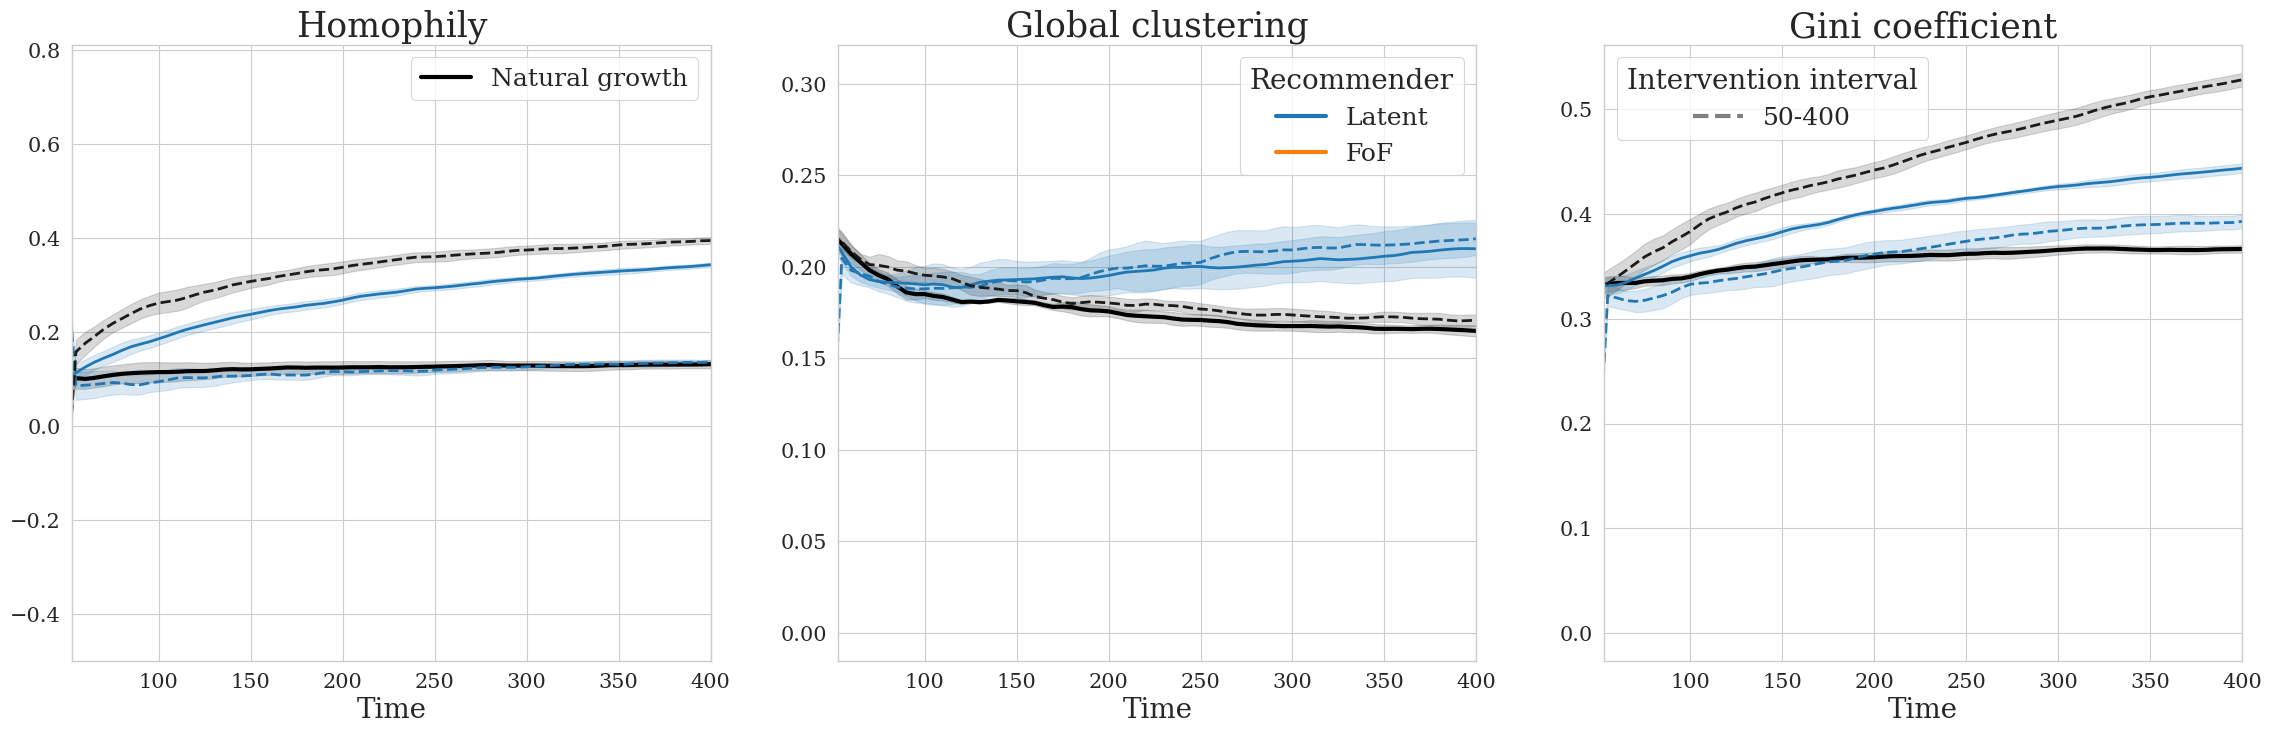

In [60]:
# plot results of AB experiments along with the counterfactual trajectories
acc_how = ['constant']
node_removal = [False]
edge_removal = [False]
adjusted = False
with context:
    metrics = ['homophily_1', 'global_clustering', 'gini_coeff']
    pretty_names = ['Homophily', 'Global clustering', 'Gini coefficient']
    plot_time=[400]
    
    for ah, nr, er in product(acc_how, node_removal, edge_removal):
        fig, ax = plt.subplots(1, 3, figsize=(28, 8),squeeze=False)

        for i, m in enumerate(metrics):
            trt = 'group1' if m == 'homophily_1' else '0.5'
            trt_metric = 'homophily_treatment' if m == 'homophily_1' else f'{m}_treatment'
            ctr_metric = 'homophily_control' if m == 'homophily_1' else f'{m}_control'
            if adjusted:
                if m != 'gini_coeff':
                    trt_metric = f'{trt_metric}_adjusted'
                if m != 'homophily_1':
                    ctr_metric = f'{ctr_metric}_adjusted'
                    
            print(trt_metric, ctr_metric)
            plot_conclusion(delayed_exp[('embedding', ah, nr, er)], 
                            m, ax=ax[0, i], pretty_name=pretty_names[i], plot_time=plot_time, add_ci=True)
            plot_conclusion(ab_exp[('embedding', ah, nr, er, trt)], trt_metric, ax=ax[0, i], pretty_name=pretty_names[i], default_ls='--',
                            plot_time=plot_time, add_ci=True, plot_ng = False, plot_range=[53, 400])
            plot_conclusion(ab_exp[('embedding', ah, nr, er, trt)], ctr_metric, ax=ax[0, i], pretty_name=pretty_names[i], default_ls='--',
                             plot_color='k', plot_time=plot_time, add_ci=True, plot_ng = False, plot_range=[53, 400])
            # plot_conclusion(delayed_exp[('random_fof',  ah, nr, er)], 
            #                 m, ax=ax[0, i], plot_color='tab:orange', pretty_name=pretty_names[i], plot_time=plot_time, add_ci=True, plot_ng=False)
            
            #ax[0, i].set_xticklabels([])
            #ax[0, i].set_xlabel('')
            # ax[i, 1].set_yticklabels([])
            ax[0, i].set_ylabel('')
            #ax[1, i].set_ylabel('')
            
        # ax[0 ,0].set_ylim([-0.05, 0.35])
        # # ax[1, 0].set_ylim([-0.05, 0.35])
        # ax[0, 1].set_ylim([0.1, 0.25])
        # # ax[1, 1].set_ylim([0.1, 0.25])
        # ax[0, 2].set_ylim([0.29, 0.48])
        # ax[1, 2].set_ylim([0.29, 0.48])

        ax[0, 0].set_title('Homophily')
        ax[0, 1].set_title('Global clustering')
        ax[0, 2].set_title('Gini coefficient')
        # ax[0, 0].set_ylabel('Latent')
        # ax[1, 0].set_ylabel('FoF')
        
        lines = [Line2D([0], [0], color='black', linewidth=3)]
        labels = ['Natural growth']
        ax[0, 0].legend(lines, labels, loc='best')
        
        lines = [Line2D([0], [0], color=c, linewidth=3) for c in ['tab:blue', 'tab:orange']]
        labels = ['Latent', 'FoF']
        ax[0,1].legend(lines, labels, loc='best', title='Recommender')

        alpha = [0.1 + 0.9 * time_range0/400 for time_range0 in plot_time]
        ls = ['--', '-.', ':', '-']
        lines = [Line2D([0], [0], color='tab:gray', linewidth=3, alpha=a, linestyle=ls[idx]) for idx, a in enumerate(alpha)]
        labels = [f'50-{time_range0}' for time_range0 in plot_time]
        ax[0, 2].legend(lines, labels, loc='best', title='Intervention interval')
        
        #plt.tight_layout()
        plt.show()
        #save_fig(fig, name=f'delayed_effects_{ah}_{nr}_{er}')
        

gini_coeff
gini_coeff_0
gini_coeff_1
gini_coeff_control
gini_coeff_control_adjusted
gini_coeff_treatment


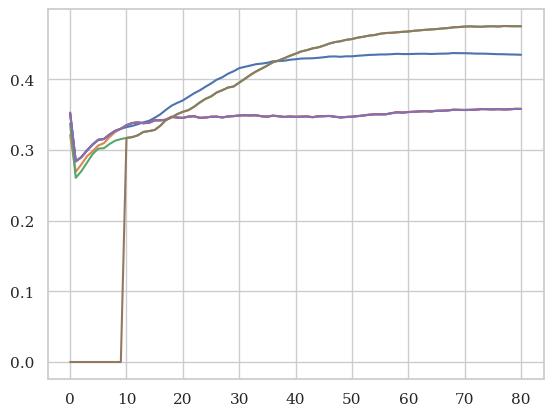

In [65]:
d = ab_exp[('embedding', 'constant', False, False, 'group1')][2][0].avg_metrics
for k in d.keys():
    if k.startswith('gini'):
        print(k)
        plt.plot(np.mean(d[k],0), label=k)

In [47]:
for key, val in d.items():
    lv = len(val[0])
    if lv != 81:
        print(f'key: {key}, val: {len(val[0])}')